In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import string

In [6]:
string_ = 'hello pytorch. how long can a rnn cell remember? show me your limit ^^'
chars = string.printable
char_list = [i for i in chars]
char_len = len(char_list)
print(char_len)

100


In [7]:
def string_to_onehot(string):
    start = np.zeros(shape=char_len ,dtype=int)
    end = np.zeros(shape=char_len ,dtype=int)
    start[-2] = 1
    end[-1] = 1
    for i in string:
        idx = char_list.index(i)
        zero = np.zeros(shape=char_len ,dtype=int)
        zero[idx]=1
        start = np.vstack([start,zero])
    output = np.vstack([start,end])
    return output

In [8]:
def onehot_to_word(onehot_1):
    onehot = torch.Tensor.numpy(onehot_1)
    return char_list[onehot.argmax()]

In [10]:
batch_size = 5
seq_len = 1
num_layers = 3
input_size = char_len
hidden_size = 100
lr = 0.01
num_epochs = 1000
one_hot = torch.from_numpy(string_to_onehot(string_)).type_as(torch.FloatTensor())

print(one_hot.size())

torch.Size([72, 100])


In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
    def forward(self,input,hidden,cell):
        output,(hidden,cell) = self.lstm(input,(hidden,cell))
        return output,hidden,cell
    
    def init_hidden_cell(self):
        hidden = torch.zeros(num_layers, batch_size, hidden_size)
        cell = torch.zeros(num_layers, batch_size, hidden_size)
        return hidden,cell
    
rnn = RNN(input_size,hidden_size, num_layers)

In [13]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(),lr = lr)

In [14]:
j=0
input_data = one_hot[j:j+batch_size].view(batch_size,seq_len,input_size)
print(input_data.size())

hidden,cell = rnn.init_hidden_cell()
print(hidden.size(),cell.size())

output,hidden,cell = rnn(input_data,hidden,cell)
print(output.size(),hidden.size(),cell.size())

torch.Size([5, 1, 100])
torch.Size([3, 5, 100]) torch.Size([3, 5, 100])
torch.Size([5, 1, 100]) torch.Size([3, 5, 100]) torch.Size([3, 5, 100])


In [16]:
loss_arr = []
unroll_len = one_hot.size()[0]//seq_len-1
for i in range(num_epochs):
  optimizer.zero_grad()
  hidden,cell = rnn.init_hidden_cell()

  loss = 0
  for j in range(unroll_len-batch_size+1):
    # batch_size에 맞게 one_hot 벡터를 stack한다.
    input_data = torch.stack([one_hot[j+k:j+k+seq_len] for k in range(batch_size)],dim=0)
    label = torch.stack([one_hot[j+k+1:j+k+seq_len+1] for k in range(batch_size)],dim=0)

    input_data = input_data
    label = label

    output,hidden,cell = rnn(input_data,hidden,cell)
    loss += loss_func(output.view(1,-1),label.view(1,-1))
  
  loss.backward()
  optimizer.step()

  if i%100 == 0:
    print(loss)
    loss_arr.append(loss)

tensor(0.7942, grad_fn=<AddBackward0>)
tensor(0.0153, grad_fn=<AddBackward0>)
tensor(0.0132, grad_fn=<AddBackward0>)
tensor(0.0131, grad_fn=<AddBackward0>)
tensor(0.0130, grad_fn=<AddBackward0>)
tensor(0.0130, grad_fn=<AddBackward0>)
tensor(0.0129, grad_fn=<AddBackward0>)
tensor(0.0129, grad_fn=<AddBackward0>)
tensor(0.0129, grad_fn=<AddBackward0>)
tensor(0.0129, grad_fn=<AddBackward0>)


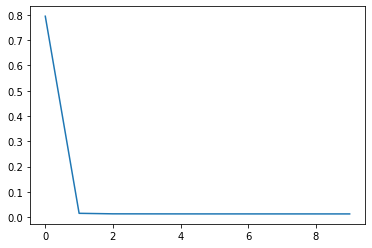

In [17]:
import matplotlib.pyplot as plt
plt.plot(loss_arr)

In [19]:
hidden,cell = rnn.init_hidden_cell()
for j in range(unroll_len - batch_size +1):
  input_data = torch.stack([one_hot[j+k:j+k+seq_len] for k in range(batch_size)],dim=0)
  label = torch.stack([one_hot[j+k+1:j+k+seq_len+1] for k in range(batch_size)],dim=0)

  output,hidden,cell = rnn(input_data,hidden,cell)
  for k in range(batch_size):
    print(onehot_to_word(output[k].data),end='')
    if j < unroll_len-batch_size:
      break

hello pytorch. how long can a rnn cell remember? show mewyour limit ^^